# Algorithmes de descentes de gradient

### *Alexandre TRENDEL, Nicolas HUBERT*


Dans ce TP nous allons implémenter les algorithmes d'optimisation  
- gradient descent (GD)
- accelerated gradient descent (AGD)
- coordinate gradient descent (CD)  

dans le cadre du modèle de régression linéaire et du modèle de régression logistique, avec pénalisation ridge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

# 1. Modèles génératifs


## 1.1 Simulation du modèle de régression linéaire


Nous commençons par simuler la matrice de design en simulant `n_samples` observations selon la loi d'un
vecteur gaussien de loi $\mathcal N_{n_{features}} (0, Corr)$.  
Nous choisissons pour $Corr$ une matrice de Toeplitz.
On simule ensuite $y_i$ selon le modèle de régression :
$$ y_i = x_i^\top w_0 + std  \ \epsilon_i $$
où $\epsilon_i \sim \mathcal{N}(0,1)$ et où $x_i \in \mathbb R^d$ est le vecteur de la i-ème observation i.e. la ligne $i$ de la matrice de design $X$.

> Compléter la fonction `simu_linreg` ci-dessous en utilisant la fonction `multivariate_normal` de numpy. Vérifier avec le bloc de code qui suit que la fonction fonctionne bien.

In [2]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(w0, n_samples=1000, corr=0.5, std=0.5):
    """Simulation of a linear regression model with Gaussian features
    and a Toeplitz covariance, with Gaussian noise.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    
    std : `float`, default=0.5
        Standard deviation of the noise

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features,), cov, size = n_samples)
    y = np.apply_along_axis(lambda xi: np.transpose(xi) @ w0 + std, 1, X)
    return X, y

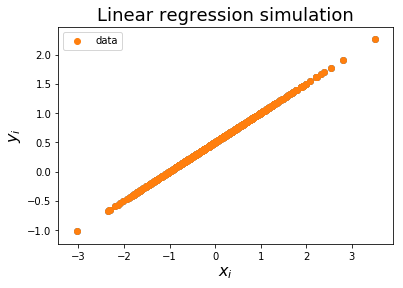

In [3]:
n_samples = 500
w0 = np.array([0.5])

X, y = simu_linreg(w0, n_samples=n_samples, corr=0.3, std=0.5)

plt.scatter(X, y)
plt.xlabel("$x_i$", fontsize=16)
plt.ylabel("$y_i$", fontsize=16)
plt.title("Linear regression simulation", fontsize=18)
plt.scatter(X, y, label='data')
plt.legend()

## 1.2 Simulation d'un modèle de régression logistique

On simule la matrice de design comme précédemment. On simule ensuite les labels $y_i$ selon le modèle de régression logistique :
$$ y_i  \sim \mathcal{B}ern(p_i)$$
avec $$ p_i = sigmoid \left( x_i^\top w_0 \right) .$$

> Compléter la fonction `simu_linreg` en utilisant les fonctions `multivariate_normal` et `random.binomial`de numpy.

In [4]:
def sigmoid(t):
    """Sigmoid function"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros((n_features)), cov, size = n_samples)
    y = np.random.binomial(n = 1, p = sigmoid(X @ w0))
    return X, y

Text(0.5,1,'Logistic regression simulation')

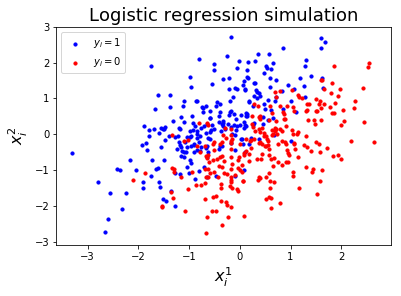

In [5]:
n_samples = 500
w0 = np.array([-3., 3.])

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == 0].T, color='r', s=10, label=r'$y_i=0$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)

# 2. Gradients et pertes

Nous voulons minimiser une fonction d'attache aux données $f$ avec une pénalisation ridge :
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
où $d$ est le nombre de features et où l'on suppose que  $f$ est $L$-smooth.  


On considère les deux modèles :

**Regression Linéaire**
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{2n} \sum_{i=1}^n (y_i - x_i^\top w)^2 + \frac{\lambda}{2} \|w\|_2^2 = \frac{1}{2 n} \| y - X w \|_2^2 + \frac{\lambda}{2} \|w\|_2^2,
$$
où $n$ est la taille de l'échantillon et $x_i \in \mathbb R^d$ est le vecteur de la i-ème observation (ligne $i$ de la matrice de design $X$).

**Regression logistique** 
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \left\{ - y_i ( x_i^\top w )  + 
\log \left(1 + \exp(x_i^\top w)  \right) 
\right\} 
+ \frac{\lambda}{2} \|w\|_2^2,
$$
où $n$ est la taille de l'échantillon  et $y_i \in \{ 0, 1 \}$ pour tout $i$.

Nous allons calculer $f(w)$, son gradient $\nabla f(w)$ et  $\frac{\partial f(w)}{\partial w_j}$ pour tout coordonnée $j$.

> Pour quel algorithme est il nécessaire de calculer $\frac{\partial f(w)}{\partial w_j}$ ?



Il est nécessaire de calculer $\frac{\partial f(w)}{\partial w_j}$ pour les algorithmes de descente de coordonnées cycliques (CGD et PCGD).

## 2.1 Une classe python pour f en régression linéaire


Notez que dans le cas de la pénalisation ridge il n'est pas nécessaire de faire appel à un opérateur proximal dans les algorithme de descente de gradient car La pénalité ridge est différentiable. 

On définit ci-dessous une classe python pour les informations sur l'attachae aux données $f$ pour le modèle de la régression linéaire. 

Voir par exemple [ici](https://www.courspython.com/classes-et-objets.html) pour quelques rappels sur les classes en python.
        
> Justifier les valeurs choisies pour les constantes de Lipschitz.


La constante de Lipschitz est majorée par la plus grand valeur propre de la matrice hessienne associée à $f$.

In [6]:
from numpy.linalg import norm


class RidgeLoss:
    
    def __init__(self, strength):
        self.strength = strength
    
    def prox(self, dw):
        return dw
    
    def loss(self, w):
        return self.strength/2 * norm(w)**2
    
    def grad(self, w):
        return self.strength * w


class ModelLinReg:
    """A class giving first order information for linear regression
    with least-squares loss.
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    """    
    def __init__(self, X, y, lossF):
        self.X = X
        self.y = y
        self.lossF = lossF
        self.n_samples, self.n_features = X.shape
        
    def prox(self, dw):
        return self.lossF.prox(dw)
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, loss = self.y, self.X, self.n_samples, self.lossF
        return 0.5 * norm(y - X.dot(w)) ** 2 / n_samples + loss.loss(w)
    
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, loss = self.y, self.X, self.n_samples, self.lossF
        return X.T.dot(X.dot(w) - y) / n_samples + loss.grad(w)

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, loss = self.y, self.X, self.n_samples, self.lossF
        return X[:, j].T.dot(X.dot(w) - y) / n_samples + loss.grad(w)[j]

    def lip(self):
        """Computes the Lipschitz constant of f"""
        X, n_samples = self.X, self.n_samples
        return norm(X.T.dot(X), 2) / n_samples + self.lossF.strength

    def lip_coordinates(self):
        """Computes the Lipschitz constant of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        return (X ** 2).sum(axis=0) / n_samples + self.lossF.strength


#### Vérification avec check_grad

On commence par définir des coefficients pour le modèle :

Text(0.5,1,'Coefficients du modèle')

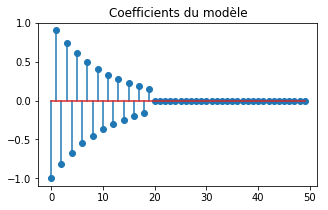

In [7]:
n_features = 50
nnz = 20
idx = np.arange(n_features, dtype=np.double)
myw0 = (-1) ** (idx - 1) * np.exp(-idx / 10.)
myw0[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(myw0)
plt.title("Coefficients du modèle")

On crée une matrice de design $X$ et un vecteur de labels $y$ avec `simu_linreg` et on crée ensuite un objet de classe `ModelLinReg` pour ces élements :

In [8]:
X, y = simu_linreg(myw0, corr=0.1)
mymodel = ModelLinReg(X, y, RidgeLoss(1e-3))

Nous allons étudier vérifier que le gradient est correctement calculé dans la classe ci-dessus, grâce à la fonction `check_grad`, voir [ici](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html).

> Quel est le rôle de w dans le code ci-dessous ? 

Ce sont les points où `check_grad` calcule une approximation du gradient.

In [9]:
w = np.random.randn(n_features)
from scipy.optimize import check_grad    
print(check_grad(mymodel.loss, mymodel.grad, w))

2.4641307138289477e-06


La classe `ModelLinReg`contient aussi des informations sur les constantes de Lipschitz du gradient :

In [10]:
print("lip=", mymodel.lip())
print("lip_coordinates=", mymodel.lip_coordinates())

lip= 1.5870489539512405
lip_coordinates= [1.07 1.09 1.04 0.98 1.06 1.   1.04 0.97 0.98 0.93 1.01 0.99 1.01 0.99
 1.03 1.03 0.97 0.98 0.93 1.01 0.94 1.02 0.98 0.93 0.97 1.04 0.93 0.93
 1.03 1.02 1.06 0.95 1.   0.96 1.03 1.01 0.99 1.   1.02 0.94 0.97 1.02
 0.93 0.97 1.06 0.94 0.94 0.94 1.04 1.01]


## 2.1 Régression logistique

**NB**: Revenir sur ces questions plus tard après avoir fini de traiter le cas de la régression linéaire.

> Compléter la classe `ModelLogReg` pour les informations sur la fonction d'attache aux données dans le cas de la régression logistique.

Dans le cas de la régression logistique, on n'arrive pas à calculer rapidement une valeur satisfaisante pour la constante de Lipschitz. On choisit donc de majorer celle-ci grossièrement par une constante indépendante de $w$ et on s'assure par la suite que le pas de gradient qui en résulte ne créée pas de problèmes.

In [75]:
from numpy.linalg import eigh

class ModelLogReg:
    """A class giving first order information for logistic regression and ridge penalization
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    """    
    def __init__(self, X, y, lossF):
        self.X = X
        self.y = y
        self.lossF = lossF
        self.n_samples, self.n_features = X.shape
        
    def prox(self, dw):
        return self.lossF.prox(dw)
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, loss = self.y, self.X, self.n_samples, self.lossF
        return 1/n_samples * np.sum(-(X @ w) * y + np.log(1 + np.exp(X @ w))) + loss.loss(w)
       
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, loss = self.y, self.X, self.n_samples, self.lossF
        E = np.exp(X @ w)/(1 + np.exp(X @ w))
        return 1/n_samples * ((X.T @ E) - (X.T @ y)) + loss.grad(w)

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        return self.grad(w)[j]
        

    def lip(self):
        """Computes the Lipschitz constant of f"""
        X, n_samples, n_features = self.X, self.n_samples, self.n_features
        # F = np.exp(X @ w)/(1 + np.exp(X @ w))**2
        # truc = np.array([[np.sum([X[j, i] * X[j, l] * F[j] for j in range(n_samples)]) for i in range(n_features)] for l in range(n_features)])
        # v, _  = eigh(1/n_samples * truc + self.lossF.strength * np.eye(n_features))
        # return v.max()
        return 1
        
    def lip_coordinates(self):
        """Computes the Lipschitz constant of f with respect to 
        the j-th coordinate"""
        #F = np.exp(X @ w)/(1 + np.exp(X @ w))**2
        #np.sum(([X[j, i] * X[j, l] * F[j] for j in range(n_samples)])
        return np.full((self.n_features), self.lip())


> Vérifier que les gradients calculés dans la classe `ModelLogReg` sont corrects, en utilisant la fonction `check_grad` et en utilisant la fonction `simu_logreg` pour définir une matrice de design et un vecteur de labels.

In [78]:
from scipy.optimize import check_grad    

idx = np.arange(50, dtype = np.double)
myw0 = (-1) ** (idx - 1) * np.exp(-idx / 10.)
X, y = simu_logreg(myw0, corr = 0.5)
mylogregmodel = ModelLogReg(X, y, RidgeLoss(1e-3))
w = np.random.randn(50)
print(check_grad(mylogregmodel.loss, mylogregmodel.grad, w))

1.5572798459074677e-07


<a id='solvers'></a>
## 3. Solveurs

Nous disposons des classes `ModelLinReg` et `ModelLogReg` qui donnent accès aux quantités $f(w)$, $\nabla f(w)$ et $\frac{\partial f(w)}{\partial w_j}$ pour la fonction objectif $f$ dans le cas de la régression linéaire et de la régression logistique. Nous allons maintenant implémenter plusieurs solveurs pour minimiser $f$.

On crée ci-dessous une classe pour les sorties des solveurs. 


In [13]:
class ReturnTraj(object):
    def __init__(self,w,obj_traj):
        self.w = w  # final weight
        self.obj_traj = obj_traj # objective trajectory

<a id='gd'></a>
## 3.1 Gradient descent

> Compléter le code de la fonction `gd` ci-dessous et tester ensuite votre fonction. Attention aux copies de listes en python, voir par exemple [ici](http://apprendre-python.com/page-apprendre-listes-list-tableaux-tableaux-liste-array-python-cours-debutant) pour des rappels sur les copies de listes.

In [41]:
def gd(model, w0_init, n_iter,verbose=True):
    """Gradient descent
    """
    step = 1 / model.lip()
    w = w0_init[:]
    obj_traj = [model.loss(w)]
    if verbose:
        print(model.loss(w))
    for k in range(n_iter + 1):
        w = model.prox(w - 1/model.lip()*model.grad(w))
        obj_traj.append(model.loss(w))        
        if verbose:
            print(model.loss(w))
    return ReturnTraj(w,obj_traj)

In [42]:
# initialisation  
w0_init = np.zeros(mymodel.n_features)
# Nombres d'itérations
n_iter = 50

In [43]:
w0_gd = gd(mymodel,w0_init,n_iter)

0.8919287237674318
0.7752400192093046
0.703529073070274
0.6512669109960891
0.6096220907383965
0.5749679379452114
0.545424837034201
0.5198546913315382
0.4974663370044396
0.4776691890191982
0.46003842393804967
0.44424880977462256
0.43004356521822557
0.41721514714382024
0.40559267423584455
0.3950240076828985
0.3853861875713891
0.3765918841181969
0.36851531929373454
0.3610976093343291
0.35428660948137464
0.3480270475678573
0.342267175492929
0.3369600715573117
0.3320640658161548
0.32754202228729323
0.3233607450516478
0.3194904802126197
0.31590449428254463
0.31257871460900405
0.3094914207876705
0.3066229783796486
0.30395560801173077
0.3014731842790422
0.2991610599085894
0.2970059114574234
0.2949956034652311
0.2931190684978091
0.29136620093432086
0.2897277626894176
0.28819529933784355
0.2867610653367708
0.2854084226039839
0.2841409582972198
0.2829526515730394
0.28183796297168173
0.2807917985895225
0.27980946371586196
0.27888662591129854
0.2780192832376911
0.2772037360141888
0.2764365613708291

Text(0.5,1,'Coefficients du modèle')

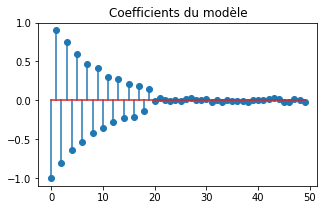

In [17]:
plt.figure(figsize=(5, 3))
plt.stem(w0_gd.w)
plt.title("Coefficients du modèle")

<a id='agd'></a>
## 3.2 Accelerated gradient descent

Nous avons vu en cours l'algorithme AGD dans le cas général des pénalisations convexes non différentiables. L'algorithme AGD dans le cas d'une pénalité différentiable correspond à la situation de l'opérateur proximal de la pénalisation nulle, c'est à dire l'opérateur identité.

> Compléter et tester la fonction `agd` ci-dessous.



In [18]:
def agd(model, w0_init, n_iter,verbose=True):
    """Accelerated gradient descent
    """

    step = 1 / model.lip()
    w = w0_init[:]
    # An extra variable is required for acceleration
    z = w0_init[:]
    t = 1.
    t_new = 1.  
    obj_traj = [model.loss(w)]
    if verbose:
        print(model.loss(w))
    for k in range(n_iter + 1):
        w_new = model.prox(z - 1/model.lip() * model.grad(w))
        t_new = 1/2 * (1 + np.sqrt(1 + 4 * t**2))
        z = w + (t - 1)/t_new * (w_new - w)
        w = w_new
        t = t_new
        obj_traj.append(model.loss(w))          
        if verbose:
            print(model.loss(w))
            
    return ReturnTraj(w,obj_traj)   

In [19]:
# initialisation  
w0_init = np.zeros(mymodel.n_features)
# Nombres d'itérations
n_iter = 50

In [20]:
w0_agd = agd(mymodel,w0_init,n_iter)

2.3057681827294996
0.591626426509159
1.4544248970143823
0.28367740824817955
0.6253562375073294
0.225654350761508
0.2450272543055368
0.1570318073679645
0.14476710286680844
0.12971679767988425
0.12559995435058877
0.12319388553289645
0.12229924161609078
0.12186987694872681
0.12168016820457804
0.12158971169090586
0.12154664441442581
0.12152579633996514
0.12151570088380552
0.12151081373910065
0.12150845592385352
0.12150732289960517
0.12150678080241362
0.12150652255451866
0.12150640004398953
0.12150634215872616
0.12150631491247511
0.12150630213410696
0.12150629616160649
0.12150629337915926
0.12150629208686747
0.12150629148842088
0.12150629121205457
0.12150629108476321
0.12150629102628122
0.12150629099947678
0.1215062909872193
0.12150629098162631
0.1215062909790795
0.12150629097792214
0.1215062909773972
0.1215062909771595
0.1215062909770521
0.12150629097700365
0.12150629097698183
0.12150629097697203
0.12150629097696755
0.12150629097696561
0.12150629097696472
0.12150629097696432
0.121506290976

Text(0.5,1,'Coefficients du modèle')

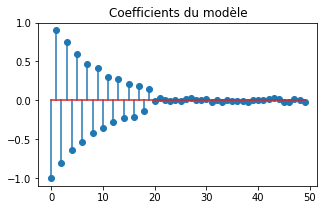

In [21]:
plt.figure(figsize=(5, 3))
plt.stem(w0_agd.w)
plt.title("Coefficients du modèle")

<a id='cgd'></a>

## 3.3 Coordinate gradient descent


> Compléter et tester la fonction `agd` ci-dessous.

In [22]:
def cgd(model, w0_init, n_iter, verbose=True):
    """Coordinate gradient descent
    """
    w = w0_init[:]
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()
    obj_traj = [model.loss(w)]    
    if verbose:
        print(model.loss(w))
    for k in range(n_iter + 1):
        #j = np.random.choice(n_features)
        j = k%n_features
        w[j] = model.prox(w[j] - 1/steps[j] * model.grad_coordinate(j, w))
        obj_traj.append(model.loss(w))        
        if verbose:
            print(model.loss(w))
    return ReturnTraj(w,obj_traj)  

In [23]:
# initialisation  
w0_init = np.zeros(mymodel.n_features)
# Nombres d'itérations
n_iter = 200

In [24]:
w0_cgd = cgd(mymodel,w0_init,n_iter)

2.3057681827294996
1.8454911940008927
1.5164929206891524
1.1924332161690756
1.0014428671741145
0.8225703596128644
0.7396109168699196
0.6343207917602909
0.5648013555278023
0.4909944839781133
0.42256849920930223
0.3518171343981285
0.31680793394859835
0.2853648689725132
0.25664700178818367
0.23203827739459357
0.21462250198002022
0.19446157543451909
0.1811419620941474
0.17566323354549795
0.16659060561386121
0.16640780805533228
0.16607754184665832
0.16596421694173907
0.16575537676263602
0.16575029875335037
0.16567253030299817
0.16552851951591427
0.16547971393630542
0.165478132029865
0.1654752904543496
0.16518074666135932
0.16436131984420937
0.16426946531447204
0.16404117129414417
0.16403952399376584
0.1638133261392346
0.1638067689456327
0.163788278153213
0.16358563157286854
0.16347430835506552
0.16342221030460338
0.16342092163030403
0.16340714282016222
0.16294784676493018
0.16264667508609737
0.16247731180534716
0.1624309185666001
0.16216315765499353
0.1621249269587765
0.1617384725946186
0.1

Text(0.5,1,'Coefficients du modèle')

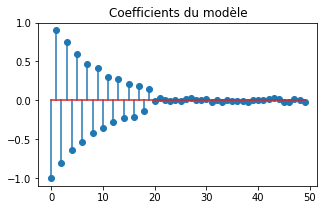

In [25]:
plt.figure(figsize=(5, 3))
plt.stem(w0_cgd.w)
plt.title("Coefficients du modèle")

<a id='comparison'></a>
# 4. Comparaison et études des algorithmes

In [26]:
w0_cgd_long = cgd(mymodel,w0_init,n_iter=1000,verbose=False)
obj_final = w0_cgd_long.obj_traj[-1] 

> Comparer les performances des 3 algorithmes en traçant en (échelles log) la valeur de la fonction objectif comparée à obj_final  en fonction du nombre de passes sur l'ensemble des données. 

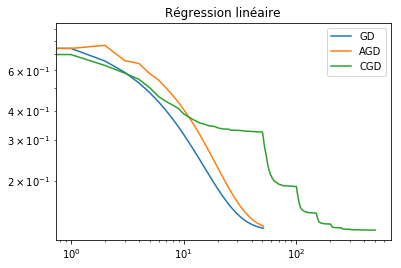

In [27]:
X, y = simu_linreg(myw0, corr=0.6)
mymodel = ModelLinReg(X, y, RidgeLoss(1e-3))
w0_init = np.zeros(mymodel.n_features)

plt.title("Régression linéaire")
plt.loglog(gd(mymodel, w0_init, n_iter = 50, verbose = False).obj_traj, label = "GD")
plt.loglog(agd(mymodel, w0_init, n_iter = 50, verbose = False).obj_traj, label = "AGD")
plt.loglog(cgd(mymodel, w0_init, n_iter = 500, verbose = False).obj_traj, label = "CGD")
plt.legend()

Les méthodes GD et AGD ont des performances comparables -- au bout de 50 itérations, la perte semble atteindre un palier. GD est un peu plus rapide dans ce cas.

La méthode CGD demande plus d'itérations pour converger vers une perte comparable, puisqu'elle n'effectue qu'un pas dans une seule direction à chaque itération. Les directions sont toujours parcourues dans le même ordre, ce qui explique la forme très particulière de la trajectoire.

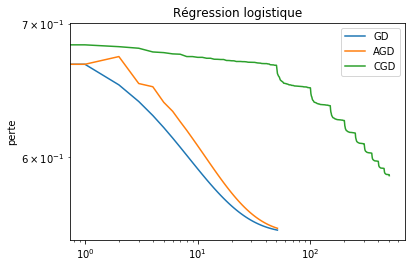

In [77]:
X, y = simu_logreg(myw0, corr=0.6)
mymodel = ModelLogReg(X, y, RidgeLoss(1e-3))
w0_init = np.zeros(mymodel.n_features)

plt.title("Régression logistique")
plt.ylabel("perte")
plt.loglog(gd(mymodel, w0_init, n_iter = 50, verbose = False).obj_traj, label = "GD")
plt.loglog(agd(mymodel, w0_init, n_iter = 50, verbose = False).obj_traj, label = "AGD")
plt.loglog(cgd(mymodel, w0_init, n_iter = 500, verbose = False).obj_traj, label = "CGD")
plt.legend()

En régression logistique, les constats sont les mêmes, même si la convergence est encore un peu plus lente pour CGD (dû au choix du pas de gradient constant, peu adaptés aux différentes directions).

> Comparer la qualité de l'estimation des coefficients du modèles pour un faible et un grand nombre d'itérations.

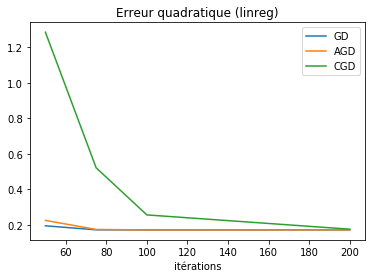

In [29]:
X, y = simu_linreg(myw0, corr=0.6)
mymodel = ModelLinReg(X, y, RidgeLoss(1e-3))
w0_init = np.zeros(mymodel.n_features)

err = lambda alg, it: np.linalg.norm(alg(mymodel, w0_init, n_iter = it, verbose = False).w - myw0)

iterations = [50, 75, 100, 200]
plt.title("Erreur quadratique (linreg)")
plt.plot(iterations, [err(gd, i) for i in iterations], label = "GD")
plt.plot(iterations, [err(agd, i) for i in iterations], label = "AGD")
plt.plot(iterations, [err(cgd, i) for i in iterations], label = "CGD")
plt.xlabel("itérations")
plt.legend()

On observe une fois de plus la même chose, à savoir que l'algorithme CGD demande plus d'itérations de par sa construction, et que GD et AGD ont des vitesses comparables dans notre cas (ce qui est un peu surprenant/décevant).

> Etudier l'influence de la corrélation sur les performances des algorithmes.

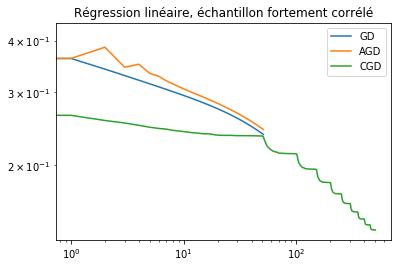

In [30]:
X, y = simu_linreg(myw0, corr=0.9)
mymodel = ModelLinReg(X, y, RidgeLoss(1e-3))
w0_init = np.zeros(mymodel.n_features)

plt.title("Régression linéaire, échantillon fortement corrélé")
plt.loglog(gd(mymodel, w0_init, n_iter = 50, verbose = False).obj_traj, label = "GD")
plt.loglog(agd(mymodel, w0_init, n_iter = 50, verbose = False).obj_traj, label = "AGD")
plt.loglog(cgd(mymodel, w0_init, n_iter = 500, verbose = False).obj_traj, label = "CGD")
plt.legend()

Pour une corrélation forte, CGD s'en sort beaucoup mieux que les autres algorithmes.

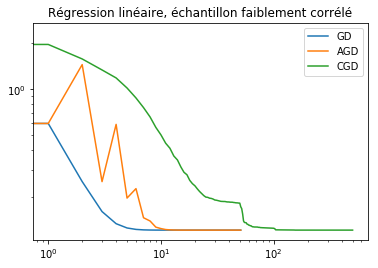

In [31]:
X, y = simu_linreg(myw0, corr=0.1)
mymodel = ModelLinReg(X, y, RidgeLoss(1e-3))
w0_init = np.zeros(mymodel.n_features)

plt.title("Régression linéaire, échantillon faiblement corrélé")
plt.loglog(gd(mymodel, w0_init, n_iter = 50, verbose = False).obj_traj, label = "GD")
plt.loglog(agd(mymodel, w0_init, n_iter = 50, verbose = False).obj_traj, label = "AGD")
plt.loglog(cgd(mymodel, w0_init, n_iter = 500, verbose = False).obj_traj, label = "CGD")
plt.legend()

Pour une corrélation faible, on retrouve les tendances précédentes en terme de vitesse. En revanche, les algorithmes semblent incapables de converge vers un minimum aussi bas que précédemment, et une perte importante subsiste à la fin.

On voit aussi que la pas de l'AGD est mal proportionné à cette situation : il semble que l'on s'écarte fréquemment de la direction de descente au départ. 

# 5. Algorithmes proximaux

> Implémenter les algorithmes GD, AGD et CGD pour le cas du modèle de la régression linéaire pénalisée par le lasso.

Pour une pénalité lasso $\Omega(w) = \lambda \Vert w \Vert_1$, on a 
\begin{equation*}
\text{prox}_\Omega (w) = \text{sign}(w) (|w| - \lambda)_+.
\end{equation*}

On modifie les classes précédentes pour externaliser la logique liée aux pertes, et on ajoute la prise en compte de l'opérateur proximal aux algorithmes de descente.

In [32]:
from numpy.linalg import norm


class LassoLoss:
   
    def __init__(self, strength):
        self.strength = strength
        
    def prox(self, dw):
        return np.sign(dw) * np.clip(np.abs(dw) - self.strength, 0, None)
    
    def loss(self, w):
        return self.strength * norm(w, ord = 1)
    
    def grad(self, w):
        return np.zeros(w.shape)


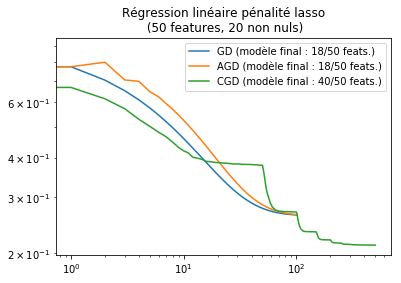

In [33]:
X, y = simu_linreg(myw0, corr=0.6)
mymodel = ModelLinReg(X, y, LassoLoss(1e-2))
w0_init = np.zeros(mymodel.n_features)

methods = [("GD", 100, gd), ("AGD", 100, agd), ("CGD", 500, cgd)]

plt.title("Régression linéaire pénalité lasso\n (50 features, 20 non nuls)")
for (name, n_iter, method) in methods:
    res = method(mymodel, w0_init, n_iter = n_iter, verbose = False)
    plt.loglog(res.obj_traj, label = "{} (modèle final : {}/50 feats.)".format(name, np.sum(res.w != 0)))
plt.legend()

Dans le cas d'une pénalisation lasso, on observe que CGD est un peu plus rapide au départ. Étonnament, CGD retient aussi plus de variables que les autres algorithmes. Pour ceux-ci, l'erreur semble atteindre un plateau assez tôt malgré une sélection de features très proche de la réalité (18 features pour 20 en réalité).